#### Importing libraries and installing dependencies

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

#avoid all warnings
import warnings
warnings.filterwarnings("ignore")

D:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#Define the randomness
np.random.seed(0)

In [3]:
#Import the NLP library and dowmload the stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Dataset

In [4]:
#Reading csv file of XML parsed ~6000 DOIs. <path> contains the file
df = pd.read_csv(r'C:\Users\Admin\OneDrive - IIT Delhi\CPCB\PROF. HARI\Jupyter_file\Ex_scibert\Abstract\final_abstract.csv')
df.head()

,Unnamed: 0,DOI,Title,Abstract
0,0,10.1016/j.tet.2021.132473,Homogeneous first-row transition metal catalys...,The recent advances in homogeneous first-row t...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning of benz...,Hydrogen production can be promoted by replaci...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells (FC) produce electricity in a conti...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition on CdS simultaneously ...,Constructing coupling reaction system is an ef...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production or photocatalytic...


In [5]:
#44 missing values are dropped. Total of 5901 abstracts are processed
df.isnull().sum() #44 missing null values

Unnamed: 0     0
DOI            0
Title          0
Abstract      44
dtype: int64

In [6]:
df = df.dropna(axis=0)
df.head()

,Unnamed: 0,DOI,Title,Abstract
0,0,10.1016/j.tet.2021.132473,Homogeneous first-row transition metal catalys...,The recent advances in homogeneous first-row t...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning of benz...,Hydrogen production can be promoted by replaci...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells (FC) produce electricity in a conti...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition on CdS simultaneously ...,Constructing coupling reaction system is an ef...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production or photocatalytic...


**ChemDataExtractor doesn't detect lowered text for catalysts/ molecular compounds. 
But lemmatization, stopword removal and punctuation removal are done prior to catalyst detection** 

#### Text Cleaning

In [7]:
#Cleaning
def clean(df, column):
    df[column] = df[column].str.replace('[^\w\s]',' ') #Removes any kind of punctuation
    df[column] = df[column].str.lstrip() #Strips of spaces from left and right ends of the abstract
    df[column] = df[column].str.rstrip()
    
#Stopword Removal
stop = stopwords.words('english')
def stop_remover(dfc, column):
    dfc[column] = dfc[column].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]
    
clean(df, 'Abstract') #Text is cleaned for punctuation and spaces
clean(df, 'Title')

stop_remover(df, 'Abstract') #Stopwords are removed
stop_remover(df, 'Title')

df['Abstract_lemm'] = df['Abstract'].apply(lemmatize_text).apply(lambda x: " ".join(x)) #All the words are lemmatized to avaoing confusion 'alcohol' & 'alcohols'
df['Title_lemm'] = df['Title'].apply(lemmatize_text).apply(lambda x: " ".join(x))

df.head()

,Unnamed: 0,DOI,Title,Abstract,Abstract_lemm,Title_lemm
0,0,10.1016/j.tet.2021.132473,Homogeneous first row transition metal catalys...,The recent advances homogeneous first row tran...,The recent advance homogeneous first row trans...,Homogeneous first row transition metal catalys...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning benzyl ...,Hydrogen production promoted replacing sluggis...,Hydrogen production promote replace sluggish o...,Selective photoelectrocatalytic tune benzyl al...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells FC produce electricity continuous m...,Fuel cells FC produce electricity continuous m...,Light alcohols reform towards renewable hydrog...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition CdS simultaneously max...,Constructing coupling reaction system effectiv...,Constructing couple reaction system effective ...,Minimized Pt deposition CdS simultaneously max...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production photocatalytic or...,Photocatalytic H2 production photocatalytic or...,Boosting photocatalytic hydrogen production co...


#### ChemDataExtractor

In [8]:
#library imported
from chemdataextractor import Document
import chemdataextractor

In [9]:
df['Compounds'] = 0

In [10]:
df = df.reset_index(drop=True)
df.head()

,Unnamed: 0,DOI,Title,Abstract,Abstract_lemm,Title_lemm,Compounds
0,0,10.1016/j.tet.2021.132473,Homogeneous first row transition metal catalys...,The recent advances homogeneous first row tran...,The recent advance homogeneous first row trans...,Homogeneous first row transition metal catalys...,0
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning benzyl ...,Hydrogen production promoted replacing sluggis...,Hydrogen production promote replace sluggish o...,Selective photoelectrocatalytic tune benzyl al...,0
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells FC produce electricity continuous m...,Fuel cells FC produce electricity continuous m...,Light alcohols reform towards renewable hydrog...,0
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition CdS simultaneously max...,Constructing coupling reaction system effectiv...,Constructing couple reaction system effective ...,Minimized Pt deposition CdS simultaneously max...,0
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production photocatalytic or...,Photocatalytic H2 production photocatalytic or...,Boosting photocatalytic hydrogen production co...,0


In [11]:
#Passing a text
for i in range(5901):
    doc = Document(df['Abstract'][i])
    array = np.array(doc.cems)
    listToStr = ' '.join([str(elem) for elem in array])
    comp_array = np.array(listToStr)
    s = comp_array.tolist().split()        
    s = list(set(s))
    listToStr2 = ' '.join([str(elem) for elem in s])
    df['Compounds'][i] = listToStr2
#Chemical entity mention
df['Compounds']

0       transition formamide bio Fe Pt C N diol hetero...
1       TiO2NTA Hydrogen hydrogen oxygen Bi2MoO6 alcoh...
2       hydrogen reforming monoxide alcohols CH4 carbo...
3       aromatic hydrogen aldehydes alcohols 2 H2 H Cd...
4       2334 μmol Fe 1h 1 alcohol MIL g H2 benzyl benz...
                              ...                        
5896                       hydrogen monoxide H2 carbon CO
5897    anhydrous ethanol 39 phenols alcohol alcohols ...
5898             metal oxide citral nerol silica alcohols
5899    MF DHMF 2 Fe3O4 dihydroxymethylfuran oxide HMF...
5900    Pd Cu propane olefins Ni olefin Al2O3 NiAl2O4 ...
Name: Compounds, Length: 5901, dtype: object

In [12]:
df.head()

,Unnamed: 0,DOI,Title,Abstract,Abstract_lemm,Title_lemm,Compounds
0,0,10.1016/j.tet.2021.132473,Homogeneous first row transition metal catalys...,The recent advances homogeneous first row tran...,The recent advance homogeneous first row trans...,Homogeneous first row transition metal catalys...,transition formamide bio Fe Pt C N diol hetero...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning benzyl ...,Hydrogen production promoted replacing sluggis...,Hydrogen production promote replace sluggish o...,Selective photoelectrocatalytic tune benzyl al...,TiO2NTA Hydrogen hydrogen oxygen Bi2MoO6 alcoh...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells FC produce electricity continuous m...,Fuel cells FC produce electricity continuous m...,Light alcohols reform towards renewable hydrog...,hydrogen reforming monoxide alcohols CH4 carbo...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition CdS simultaneously max...,Constructing coupling reaction system effectiv...,Constructing couple reaction system effective ...,Minimized Pt deposition CdS simultaneously max...,aromatic hydrogen aldehydes alcohols 2 H2 H Cd...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production photocatalytic or...,Photocatalytic H2 production photocatalytic or...,Boosting photocatalytic hydrogen production co...,2334 μmol Fe 1h 1 alcohol MIL g H2 benzyl benz...


#### Word cloud

In [13]:
#!pip install wordcloud

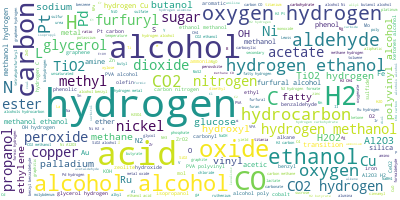

In [14]:
from wordcloud import WordCloud

# Joining all the processed lines together. Whole PDF
long_string = ','.join([str(i) for i in list(df['Compounds'].values)])

# WordCloud object
wordcloud = WordCloud(background_color="white", 
                      max_words=100000, 
                      contour_width=5, 
                      contour_color='steelblue',
                      repeat = False,
                      relative_scaling = 0.5,
                      min_font_size=3,
                      max_font_size = 40)
wordcloud.generate(long_string)

# Visualizing
wordcloud.to_image()

In [15]:
#Lemmatized abstract is converted to lower case
df['Abstract_lemm'] = df['Abstract_lemm'].str.lower()
df.head()

,Unnamed: 0,DOI,Title,Abstract,Abstract_lemm,Title_lemm,Compounds
0,0,10.1016/j.tet.2021.132473,Homogeneous first row transition metal catalys...,The recent advances homogeneous first row tran...,the recent advance homogeneous first row trans...,Homogeneous first row transition metal catalys...,transition formamide bio Fe Pt C N diol hetero...
1,1,10.1016/j.apcatb.2020.119868,Selective photoelectrocatalytic tuning benzyl ...,Hydrogen production promoted replacing sluggis...,hydrogen production promote replace sluggish o...,Selective photoelectrocatalytic tune benzyl al...,TiO2NTA Hydrogen hydrogen oxygen Bi2MoO6 alcoh...
2,2,10.1016/j.rser.2020.110523,Light alcohols reforming towards renewable hyd...,Fuel cells FC produce electricity continuous m...,fuel cells fc produce electricity continuous m...,Light alcohols reform towards renewable hydrog...,hydrogen reforming monoxide alcohols CH4 carbo...
3,3,10.1016/j.apsusc.2021.150446,Minimized Pt deposition CdS simultaneously max...,Constructing coupling reaction system effectiv...,constructing couple reaction system effective ...,Minimized Pt deposition CdS simultaneously max...,aromatic hydrogen aldehydes alcohols 2 H2 H Cd...
4,4,10.1016/j.cej.2021.129870,Boosting photocatalytic hydrogen production co...,Photocatalytic H2 production photocatalytic or...,photocatalytic h2 production photocatalytic or...,Boosting photocatalytic hydrogen production co...,2334 μmol Fe 1h 1 alcohol MIL g H2 benzyl benz...


## LDA

* [Reference 1](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
* [Reference 2](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)
* [Reference 3](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-e7ff75290f8)
* [Reference 4](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

In [16]:
#Tokenize words and further clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        
data = df['Abstract_lemm'].tolist()
data_words = list(sent_to_words(data))

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['recent_advance', 'homogeneous', 'first', 'row', 'transition_metal', 'catalyze', 'hydrogen', 'production', 'important', 'organic', 'transformation', 'methanol', 'fa', 'bio', 'alcohol', 'current', 'interest', 'important', 'paradigm', 'chemical', 'synthesis', 'development', 'sustainable', 'catalysis', 'early', 'work', 'mainly', 'base', 'catalyst', 'present', 'focus', 'mainly', 'earth_abundant', 'base', 'metal', 'complex', 'show', 'grow', 'interest', 'highly', 'elusive', 'demand', 'modern', 'science', 'due', 'low', 'cost', 'less', 'toxic', 'abundance', 'review', 'mainly', 'aim', 'describe', 'topic', 'hydrogen', 'formation', 'organic', 'transformation', 'methanol', 'alcohol', 'methylation', 'methylation', 'formamide', 'formation', 'methanol', 'heterocycle', 'lactam', 'lactone', 'hydrogen', 'formation', 'diol', 'bioalcohol', 'hydrogen', 'formation', 'storage', 'capability', 'liquid', 'organic', 'hydrogen', 'carrier', 'additionally', 'pay', 'utility', 'reaction', 'include', 'brief', 'react

In [20]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 4), (30, 1), (31, 1), (32, 1), (33, 1), (34, 5), (35, 2), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 3), (44, 1), (45, 1), (46, 3), (47, 2), (48, 1), (49, 3), (50, 1), (51, 1), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1)]]


## Base Model

Code for Base model LDA with default alpha and beta values

In [36]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [37]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"film" + 0.008*"sensor" + 0.008*"compound" + 0.007*"sense" + '
  '0.006*"sample" + 0.006*"test" + 0.006*"drug" + 0.005*"detection" + '
  '0.005*"wine" + 0.005*"concentration"'),
 (1,
  '0.023*"reaction" + 0.020*"hydrogen" + 0.016*"temperature" + 0.015*"high" + '
  '0.013*"co" + 0.013*"gas" + 0.013*"product" + 0.012*"yield" + '
  '0.012*"ethanol" + 0.011*"alcohol"'),
 (2,
  '0.022*"pva" + 0.018*"alcohol" + 0.010*"film" + 0.009*"bond" + '
  '0.009*"property" + 0.008*"show" + 0.008*"polymer" + 0.007*"result" + '
  '0.007*"surface" + 0.007*"structure"'),
 (3,
  '0.033*"alcohol" + 0.011*"activity" + 0.011*"induce" + 0.011*"cell" + '
  '0.010*"increase" + 0.010*"level" + 0.010*"enzyme" + 0.010*"ethanol" + '
  '0.009*"effect" + 0.008*"study"'),
 (4,
  '0.066*"catalyst" + 0.022*"hydrogenation" + 0.021*"reaction" + '
  '0.020*"catalytic" + 0.018*"high" + 0.016*"support" + 0.016*"alcohol" + '
  '0.015*"selectivity" + 0.013*"co" + 0.013*"activity"'),
 (5,
  '0.016*"hydrogen" + 0.014

In [38]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4492665764675478


Coherence Score is a measure for performance of LDA. LDA model is run mutliple times in a loop to maximize the coherence score for hyperparameters number of topics, alpha and beta.

In [39]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [40]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  1%|▉                                                                               | 6/540 [02:58<4:30:10, 30.36s/it]

KeyboardInterrupt: 

## Analysis

In [41]:
a1 = pd.read_csv(r'C:\Users\Admin\OneDrive - IIT Delhi\CPCB\PROF. HARI\Jupyter_file\Ex_scibert\Abstract\lda_tuning_results.csv')
a1.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.392252
1,75% Corpus,2,0.01,0.31,0.387186
2,75% Corpus,2,0.01,0.61,0.396402
3,75% Corpus,2,0.01,0.9099999999999999,0.396402
4,75% Corpus,2,0.01,symmetric,0.377741


In [42]:
dd = pd.DataFrame()
dd  = a1.loc[(a1.Alpha == '0.61') & (a1.Beta == '0.31') & (a1.Validation_Set == '75% Corpus')]
#dd = a1.loc[a1.Topics == 9]
dd.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
12,75% Corpus,2,0.61,0.61,0.412808
42,75% Corpus,3,0.61,0.61,0.382847
72,75% Corpus,4,0.61,0.61,0.392846
102,75% Corpus,5,0.61,0.61,0.424427
132,75% Corpus,6,0.61,0.61,0.411924


In [43]:
dd.Coherence.nlargest(2)

222    0.502366
192    0.469980
Name: Coherence, dtype: float64

In [44]:
a1.loc[221]

Validation_Set    75% Corpus
Topics                     9
Alpha                   0.61
Beta                    0.31
Coherence           0.489087
Name: 221, dtype: object

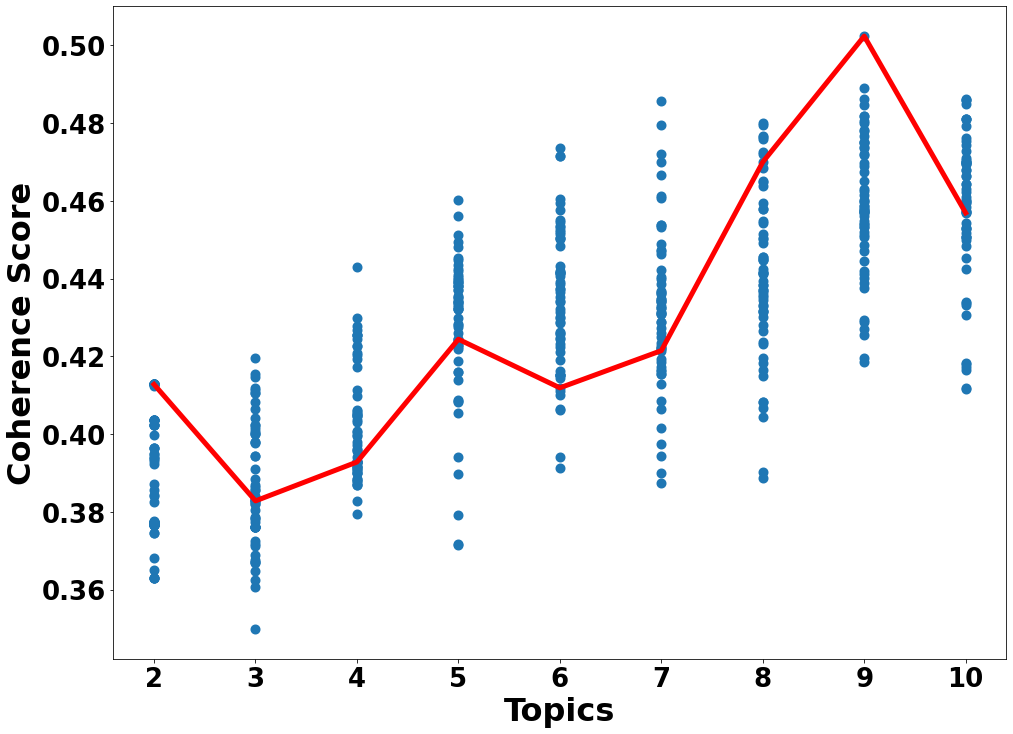

In [71]:
import matplotlib.pyplot as plt

x = dd['Topics']
y = dd['Coherence']

plt.figure(figsize = (16, 12), linewidth = 20)
plt.plot(x, y, c='r', linewidth=5)
plt.scatter(a1['Topics'], a1['Coherence'], linewidths=4)
plt.xlabel('Topics', fontweight='bold', fontsize=32)
plt.ylabel('Coherence Score', fontweight='bold', fontsize=32)
plt.xticks(fontweight='bold', fontsize=26)
plt.yticks(fontweight='bold', fontsize=26)
#plt.title('LDA: Topics vs Coherence Score (alpha=0.61, beta=0.61)', fontweight='bold', fontsize=28)
plt.savefig(r'C:\Users\Admin\OneDrive - IIT Delhi\CPCB\PROF. HARI\data_final\coherence.pdf', dpi=5000)
plt.show()


In [46]:
maximum_Coherence = a1.Coherence.max()
maxValueIndex = a1.Coherence.idxmax()
print(maximum_Coherence, maxValueIndex)

0.5023657677932688 222


In [47]:
a1.loc[222]

Validation_Set    75% Corpus
Topics                     9
Alpha                   0.61
Beta                    0.61
Coherence           0.502366
Name: 222, dtype: object

## Final Model

In [28]:
import random 
random.seed(0)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.61,
                                           eta=0.31)

In [29]:
pprint(lda_model.print_topics())

[(0,
  '0.008*"coal" + 0.007*"compound" + 0.007*"sodium" + 0.007*"wine" + '
  '0.005*"clay" + 0.005*"biofilm" + 0.005*"sugar" + 0.005*"fruit" + '
  '0.004*"food" + 0.004*"resistant"'),
 (1,
  '0.027*"hydrogen" + 0.021*"reaction" + 0.019*"temperature" + 0.016*"gas" + '
  '0.014*"high" + 0.014*"ethanol" + 0.012*"yield" + 0.012*"product" + '
  '0.011*"increase" + 0.011*"co"'),
 (2,
  '0.019*"pva" + 0.011*"film" + 0.010*"alcohol" + 0.008*"property" + '
  '0.008*"show" + 0.007*"polymer" + 0.007*"increase" + 0.007*"result" + '
  '0.007*"bond" + 0.006*"study"'),
 (3,
  '0.028*"alcohol" + 0.010*"activity" + 0.010*"induce" + 0.010*"cell" + '
  '0.009*"enzyme" + 0.008*"level" + 0.008*"increase" + 0.008*"ethanol" + '
  '0.007*"effect" + 0.007*"study"'),
 (4,
  '0.057*"catalyst" + 0.021*"reaction" + 0.018*"hydrogenation" + '
  '0.018*"catalytic" + 0.017*"high" + 0.016*"alcohol" + 0.014*"co" + '
  '0.014*"support" + 0.013*"selectivity" + 0.012*"activity"'),
 (5,
  '0.024*"hydrogen" + 0.017*"tio" + 

In [30]:
#import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.135491  0.129695  1       1        21.209416
8     -0.054242 -0.127776  2       1        16.556457
5     -0.111998  0.118334  3       1        14.024870
6     -0.048250 -0.151739  4       1        12.585717
1     -0.112784 -0.094620  5       1        12.389310
2     -0.010621  0.129456  6       1        9.852051 
3      0.145029 -0.006945  7       1        6.089004 
7      0.041992 -0.029688  8       1        5.892837 
0      0.286366  0.033282  9       1        1.400338 , topic_info=            Term         Freq        Total Category  logprob  loglift
11    catalyst    6845.000000  6845.000000  Default  30.0000  30.0000
53    production  6397.000000  6397.000000  Default  29.0000  29.0000
34    hydrogen    9220.000000  9220.000000  Default  28.0000  28.0000
3     alcohol     4492.000000  4492.000000  Default  27.0000  27.0000
134   fuel        2021.000000  2021.000000  Default  26.0000  26.0000
...    ...                ...          ...      ...      ...      ...
900   quality     17.545431    151.051730   Topic9  -6.0421   2.1156 
2874  bacteria    18.670219    291.933466   Topic9  -5.9800   1.5189 
2337  extract     16.684804    173.276918   Topic9  -6.0924   1.9281 
467   natural     15.823396    235.510643   Topic9  -6.1454   1.5682 
774   sample      15.053539    587.479720   Topic9  -6.1953   0.6042 

[621 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1068  2      0.047057  absolute        
1068  8      0.894090  absolute        
3715  4      0.963822  acetate_butyrate
400   1      0.392967  acid            
400   2      0.000992  acid            
...  ..           ...   ...            
270   8      0.000410  yield           
953   1      0.889697  zeolite         
953   6      0.098128  zeolite         
4917  1      0.936701  zirconia        
271   3      0.990713  μmol            

[1698 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 6, 7, 2, 3, 4, 8, 1])

In [31]:
#most dominant topic for each document
doc_lda = lda_model[corpus]

corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in doc_lda]
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=10)] for n in range(0, lda_model.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 11)], index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Term1,coal,hydrogen,pva,alcohol,catalyst,hydrogen,production,membrane,hydrogen
Term2,compound,reaction,film,activity,reaction,tio,hydrogen,alcohol,fuel
Term3,sodium,temperature,alcohol,induce,hydrogenation,photocatalytic,yield,model,production
Term4,wine,gas,property,cell,catalytic,production,concentration,water,energy
Term5,clay,high,show,enzyme,high,high,high,temperature,process


In [32]:
# column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df.head()

,Terms per Topic
Topic1,"coal, compound, sodium, wine, clay, biofilm, sugar, fruit, food, resistant"
Topic2,"hydrogen, reaction, temperature, gas, high, ethanol, yield, product, increase, co"
Topic3,"pva, film, alcohol, property, show, polymer, increase, result, bond, study"
Topic4,"alcohol, activity, induce, cell, enzyme, level, increase, ethanol, effect, study"
Topic5,"catalyst, reaction, hydrogenation, catalytic, high, alcohol, co, support, selectivity, activity"


In [33]:
topics_df.columns, topics_df['Terms per Topic'][0]

(Index(['Terms per Topic'], dtype='object'),
 'coal, compound, sodium, wine, clay, biofilm, sugar, fruit, food, resistant')

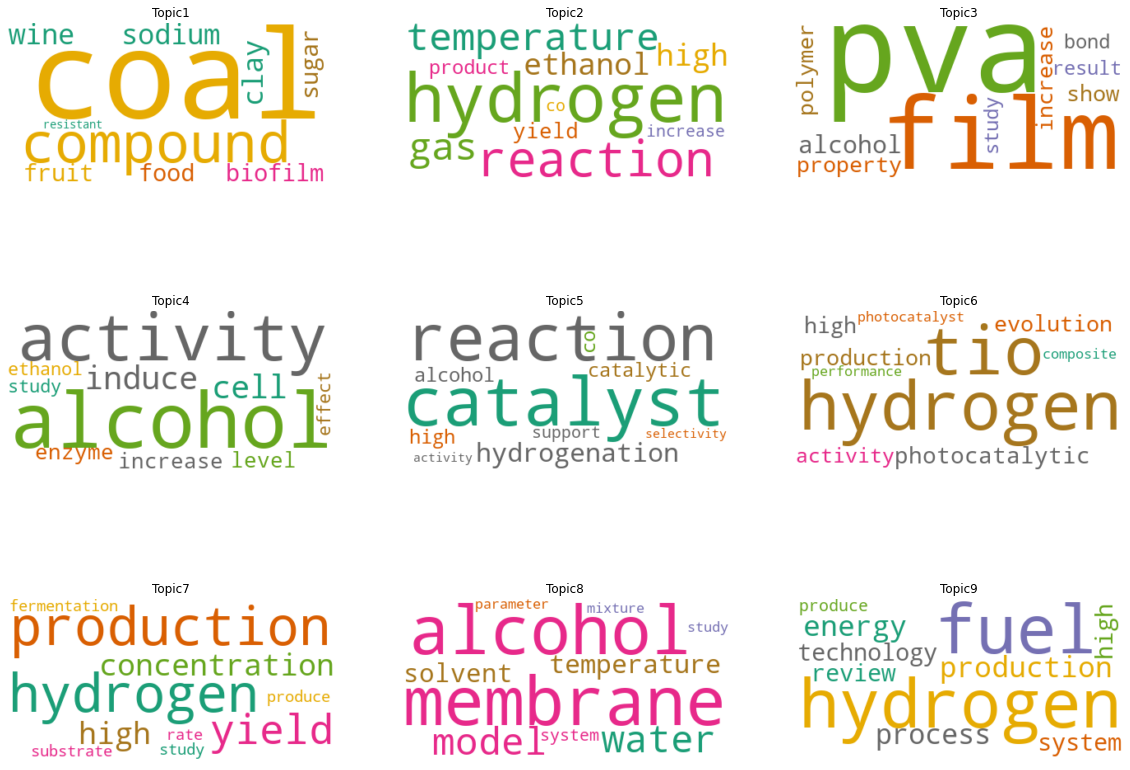

In [34]:
#Visualizing with word clouds
from wordcloud import WordCloud
#wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

#figure size
plt.rcParams['figure.figsize'] = [20, 15]

#subplots for each topic
for i in range(9):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(3, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [35]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.5600,"hydrogen, fuel, production, energy, process, technology, review, system, high, produce","[recent_advance, homogeneous, first, row, transition_metal, catalyze, hydrogen, production, important, organic, transformation, methanol, fa, bio, alcohol, current, interest, important, paradigm, chemical, synthesis, development, sustainable, catalysis, early, work, mainly, base, catalyst, present, focus, mainly, earth_abundant, base, metal, complex, show, grow, interest, highly, elusive, demand, modern, science, due, low, cost, less, toxic, abundance, review, mainly, aim, describe, topic, hydrogen, formation, organic, transformation, methanol, alcohol, methylation, methylation, formamide, formation, methanol, heterocycle, lactam, lactone, hydrogen, formation, diol, bioalcohol, hydrogen, formation, storage, capability, liquid, organic, hydrogen, carrier, additionally, pay, utility, reaction, include, brief, reaction, mechanism, scope, reaction]"
1,1,5.0,0.4449,"hydrogen, tio, photocatalytic, production, high, evolution, activity, photocatalyst, performance, composite","[hydrogen, production, promote, replace, sluggish, oxygen, evolution, reaction, oer, favorable, reaction, primary, oxidation, reaction, benzyl, alcohol, benzaldehyde, tio, benzaldehyde, realize, selectivity, originate, adsorption, activation, benzyl, alcohol, photoanode, confirm, test, situ, technique, electron, generate, controllable, selective, primary, oxidation, reaction, utilize, source, synergistical, hydrogen, production, amount, generate, hydrogen, time, high, efficiency, hydrogen, production, high, propose, strategy, combine, solar, energy, biomass, efficient, production, valuable, raw_material, benzaldehyde, well, green, energy, source, hydrogen]"
2,2,8.0,0.5444,"hydrogen, fuel, production, energy, process, technology, review, system, high, produce","[fuel, cell, produce, electricity, continuous, mode, catalytic, reaction, many, possible, application, example, transportation_sector, substitute, device, regard, free, emission, technology, fuel, obtain, renewable, mode, hydrogen, reform, light, alcohol, obtain, biomass, fermentation, gasification, fact, proton_exchange, membrane, fuel, cell, pemfc, hydrogen, fuel, turn, free, co, later, chemical, specie, poison, platinum, base, catalyst, apply, electrochemical, process, review, aim, clarify, multicomponent, catalyst, hydrogen, production, light, alcohol, reform, current, catalyst, specifically, low, thermal, stability, co, formation, suitable, carbon, coke, production, poison, reform, catalyst, byproduct, ch, generation, reduce, hydrogen, amount, produce, special_emphasis, pay, applicability, theoretical, method, study, development, improve, multicomponent, catalyst, light, alcohol, reform]"
3,3,5.0,0.8287,"hydrogen, tio, photocatalytic, production, high, evolution, activity, photocatalyst, performance, composite","[construct, couple, reaction, system, effective, strategy, simultaneously, improve, utilization, photoexcited_electron, hole, cd, photocatalyst, minimize, develop, novel, method, couple, system, hydrogen, production, aromatic, alcohol, oxidation, cd, exhibit, enhance, production, rat, aromatic, aldehyde, mmol, gcat, respectively, time, high, pure, cd, furthermore, apparent_quantum, efficiency_aqe, hydrogen, production, nm, palpable, decrease, photoactivity, continuous, test, enhance, photocatalytic, activity, mainly, attribute, synergistic, role, pt, cd, large, interfacial, area, form, tight, anchorage, pt, cd, favorable, transfer, photoexcited_electron, ensure, outstanding, mobility, offer, active_sit, reduce, photoexcite, hole, leave, cd, oxidize, aromatic, alcohol, correspond, aldehyde, thereby, achieve, simultaneous, utilization, photoexcite, reaction, system, anchor, design, also, expand, couple, system]"
4,4,5.0,0.8157,"hydrogen, tio, photocatalytic, production, high, evolution, activity, photocatalyst, performance, composit

In [36]:
df_dominant_topic.Dominant_Topic.value_counts()

4.0    1588
5.0    941 
8.0    858 
6.0    786 
1.0    623 
2.0    527 
3.0    301 
7.0    246 
0.0    31  
Name: Dominant_Topic, dtype: int64

In [37]:
topics_df.columns, topics_df['Terms per Topic'][8]

(Index(['Terms per Topic'], dtype='object'),
 'hydrogen, fuel, production, energy, process, technology, review, system, high, produce')

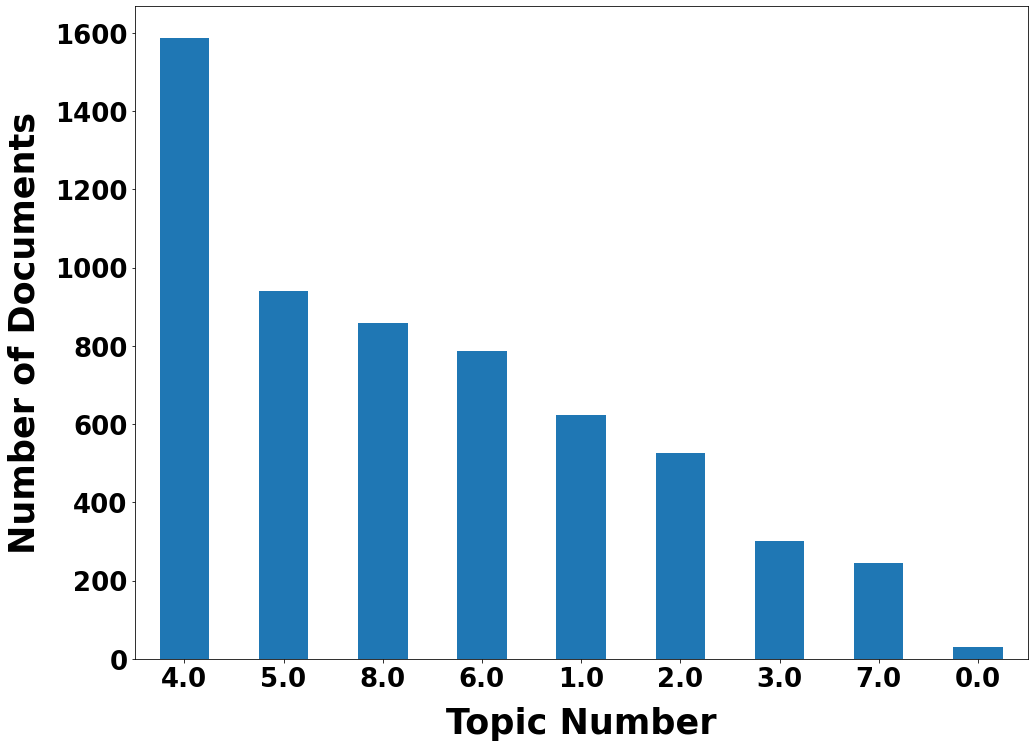

In [39]:
df_dominant_topic.Dominant_Topic.value_counts().plot(kind='bar', rot=0, figsize = (16, 12), linewidth = 20)
plt.xlabel("Topic Number", labelpad=14, fontweight='bold', fontsize=35)
plt.ylabel("Number of Documents", labelpad=14, fontweight='bold', fontsize=35)
plt.xticks(fontweight='bold', fontsize=26)
plt.yticks(fontweight='bold', fontsize=26)
plt.savefig(r'C:\Users\Admin\OneDrive - IIT Delhi\CPCB\PROF. HARI\data_final\bar_plot.pdf', dpi=5000)
plt.show()

In [40]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(12)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7125,"coal, compound, sodium, wine, clay, biofilm, sugar, fruit, food, resistant","[background, compound, high, antiviral, antibacterial, activity, divalent, copper, compound, com..."
1,1.0,0.9461,"hydrogen, reaction, temperature, gas, high, ethanol, yield, product, increase, co","[hydrogen, migration, distribution, characteristic, product, co, pyrolysis, lignite, hydrogen, r..."
2,2.0,0.9518,"pva, film, alcohol, property, show, polymer, increase, result, bond, study","[smart, package, film, prepare, individually, add, free, lycium, ruthenicum, anthocyanin, anthoc..."
3,3.0,0.9656,"alcohol, activity, induce, cell, enzyme, level, increase, ethanol, effect, study","[excessive, alcohol, user, high, risk, develop, respiratory, infection, compare, individual, chr..."
4,4.0,0.9554,"catalyst, reaction, hydrogenation, catalytic, high, alcohol, co, support, selectivity, activity","[perovskite, perform, several, technique, include, tprs, solid, test, catalyst, hydrogenation, c..."
5,5.0,0.9503,"hydrogen, tio, photocatalytic, production, high, evolution, activity, photocatalyst, performance...","[srtio, tio, nanoparticle, modify, tio, tio, nta, construct, follow, step, firstly, highly, orde..."
6,6.0,0.9521,"production, hydrogen, yield, concentration, high, fermentation, rate, produce, substrate, study","[study, evaluate, feasibility, ch, production, two_stage, thermophilic, anaerobic_digestion, sug..."
7,7.0,0.9420,"membrane, alcohol, model, water, temperature, solvent, system, parameter, mixture, study","[widely, permeation, water, alcohol, mixture, microporous, membrane, pervaporation, dehydration,..."
8,8.0,0.9633,"hydrogen, fuel, production, energy, process, technology, review, system, high, produce","[substitution, conventional, jet, fuel, low, carbon, emit, alternative, aviation, fuel, vital, m..."


In [41]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(12)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7125,"coal, compound, sodium, wine, clay, biofilm, sugar, fruit, food, resistant","[background, compound, high, antiviral, antibacterial, activity, divalent, copper, compound, com..."
1,1.0,0.9461,"hydrogen, reaction, temperature, gas, high, ethanol, yield, product, increase, co","[hydrogen, migration, distribution, characteristic, product, co, pyrolysis, lignite, hydrogen, r..."
2,2.0,0.9518,"pva, film, alcohol, property, show, polymer, increase, result, bond, study","[smart, package, film, prepare, individually, add, free, lycium, ruthenicum, anthocyanin, anthoc..."
3,3.0,0.9656,"alcohol, activity, induce, cell, enzyme, level, increase, ethanol, effect, study","[excessive, alcohol, user, high, risk, develop, respiratory, infection, compare, individual, chr..."
4,4.0,0.9554,"catalyst, reaction, hydrogenation, catalytic, high, alcohol, co, support, selectivity, activity","[perovskite, perform, several, technique, include, tprs, solid, test, catalyst, hydrogenation, c..."
5,5.0,0.9503,"hydrogen, tio, photocatalytic, production, high, evolution, activity, photocatalyst, performance...","[srtio, tio, nanoparticle, modify, tio, tio, nta, construct, follow, step, firstly, highly, orde..."
6,6.0,0.9521,"production, hydrogen, yield, concentration, high, fermentation, rate, produce, substrate, study","[study, evaluate, feasibility, ch, production, two_stage, thermophilic, anaerobic_digestion, sug..."
7,7.0,0.9420,"membrane, alcohol, model, water, temperature, solvent, system, parameter, mixture, study","[widely, permeation, water, alcohol, mixture, microporous, membrane, pervaporation, dehydration,..."
8,8.0,0.9633,"hydrogen, fuel, production, energy, process, technology, review, system, high, produce","[substitution, conventional, jet, fuel, low, carbon, emit, alternative, aviation, fuel, vital, m..."


In [44]:
#most dominant topic for each document
doc_lda = lda_model[corpus]

corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in doc_lda]
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=50)] for n in range(0, lda_model.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 51)], index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Term1,coal,hydrogen,pva,alcohol,catalyst,hydrogen,production,membrane,hydrogen
Term2,compound,reaction,film,activity,reaction,tio,hydrogen,alcohol,fuel
Term3,sodium,temperature,alcohol,induce,hydrogenation,photocatalytic,yield,model,production
Term4,wine,gas,property,cell,catalytic,production,concentration,water,energy
Term5,clay,high,show,enzyme,high,high,high,temperature,process


In [45]:
# column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"coal, compound, sodium, wine, clay, biofilm, sugar, fruit, food, resistant, pulp, emulsion, ester, salt, chloride, volatile, yeast, buten_ol, color, bacteria, age, cerevisiae, win, quality, extract, natural, cotton, sample, succinic, mussel, isolate, antibiotic, disinfectant, log, worker, grape, sac, antibacterial, longan, juice, sensory, live, ferrosilicon, cut, borax, bacterial, pulcherrima, beer, ferment, contain"
Topic2,"hydrogen, reaction, temperature, gas, high, ethanol, yield, product, increase, co, reactor, production, process, ratio, water, glycerol, methanol, result, condition, reform, carbon, study, produce, low, conversion, effect, investigate, pyrolysis, pressure, compound, show, bio_oil, formation, obtain, hydrocarbon, time, oxygen, liquid, methane, ch, concentration, decomposition, mixture, content, gasification, different, rate, biomass, flow, fee"
Topic3,"pva, film, alcohol, property, show, polymer, increase, result, bond, study, structure, water, composite, material, high, surface, complex, prepare, adsorption, solution, thermal, effect, concentration, form, analysis, nanoparticle, peroxide, oxidation, improve, matrix, polyvinyl, base, application, interaction, also, process, addition, investigate, method, low, well, stability, hydrogen, time, go, coat, content, different, indicate, molecule"
Topic4,"alcohol, activity, induce, cell, enzyme, level, increase, ethanol, effect, study, result, reduce, protein, show, treatment, also, consumption, role, decrease, expression, group, liver, antioxidant, gene, mechanism, high, cause, production, metabolism, peroxide, significantly, control, exposure, factor, damage, potential, stress, demonstrate, rat, compare, produce, disease, hydrogenase, dehydrogenase, toxicity, associate, mutant, suggest, oxidase, relate"
Topic5,"catalyst, reaction, hydrogenation, catalytic, high, alcohol, co, support, selectivity, activity, metal, conversion, show, prepare, surface, performance, result, carbon, formation, phase, base, reduction, study, selective, active, synthesis, yield, specie, method, cu, condition, also, product, different, low, structure, nanoparticle, increase, temperature, find, obtain, characterize, effect, sit, oxide, acid, test, good, investigate, synthesize"
Topic6,"hydrogen, tio, photocatalytic, production, high, evolution, activity, photocatalyst, performance, composite, efficient, reaction, enhance, rate, cd, nanoparticle, structure, efficiency, surface, material, prepare, electron, work, method, time, exhibit, show, visible_light, improve, synthesize, result, generation, energy, transfer, carbon, water, irradiation, solar, solution, low, electrochemical, electrode, provide, light, excellent, dope, charge, strategy, pt, stability"
Topic7,"production, hydrogen, yield, concentration, high, fermentation, rate, produce, substrate, study, respectively, maximum, condition, reactor, increase, result, process, glucose, acid, show, culture, obtain, effect, methane, wastewater, time, pretreatment, waste, cod, ph, batch, investigate, organic, ml, bacteria, treatment, strain, hrt, anaerobic, medium, continuous, ethanol, growth, biomass, efficiency, analysis, achieve, control, ratio, temperature"
Topic8,"membrane, alcohol, model, water, temperature, solvent, system, parameter, mixture, study, oil, separation, kinetic, phase, result, experimental, liquid, extraction, value, obtain, calculate, measure, ethanol, process, methanol, low, simulation, datum, determine, range, predict, hydrogen, work, cell, high, show, butanol, interaction, solubility, find, thermodynamic, property, density, solution, base, concentration, equation, method, permeation, pressure"
Topic9,"hydrogen, fuel, production, energy, process, technology, review, system, high, produce, cell, also, cost, base, application, renewable, biomass, emission, source, alternative, biodiesel, efficiency, low, discuss, engine, development, research, method, chemical, present, diesel, potential, combusti

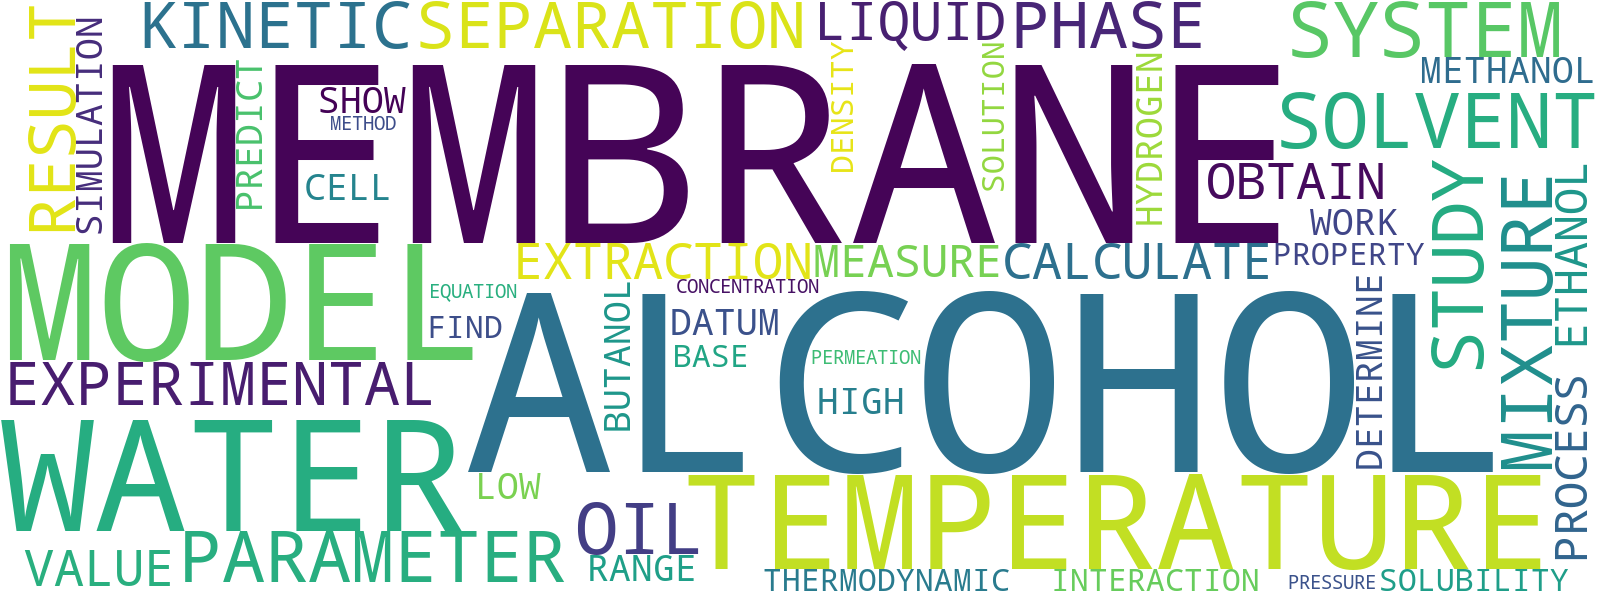

In [46]:
from wordcloud import WordCloud

# Joining all the processed lines together. Whole PDF
long_string = ','.join([str(i) for i in list(topics_df['Terms per Topic'][3])])
# WordCloud object
wordcloud = WordCloud(background_color="white",
                      max_words=100000, 
                      contour_width=5, 
                      contour_color='steelblue',
                      repeat = False,
                      relative_scaling = 0.5,
                      min_font_size=10,
                      max_font_size = 250,
                      width=1600,
                      height=600)
wordcloud.generate(text=topics_df["Terms per Topic"][7].upper())

# Visualizing
wordcloud.to_image()

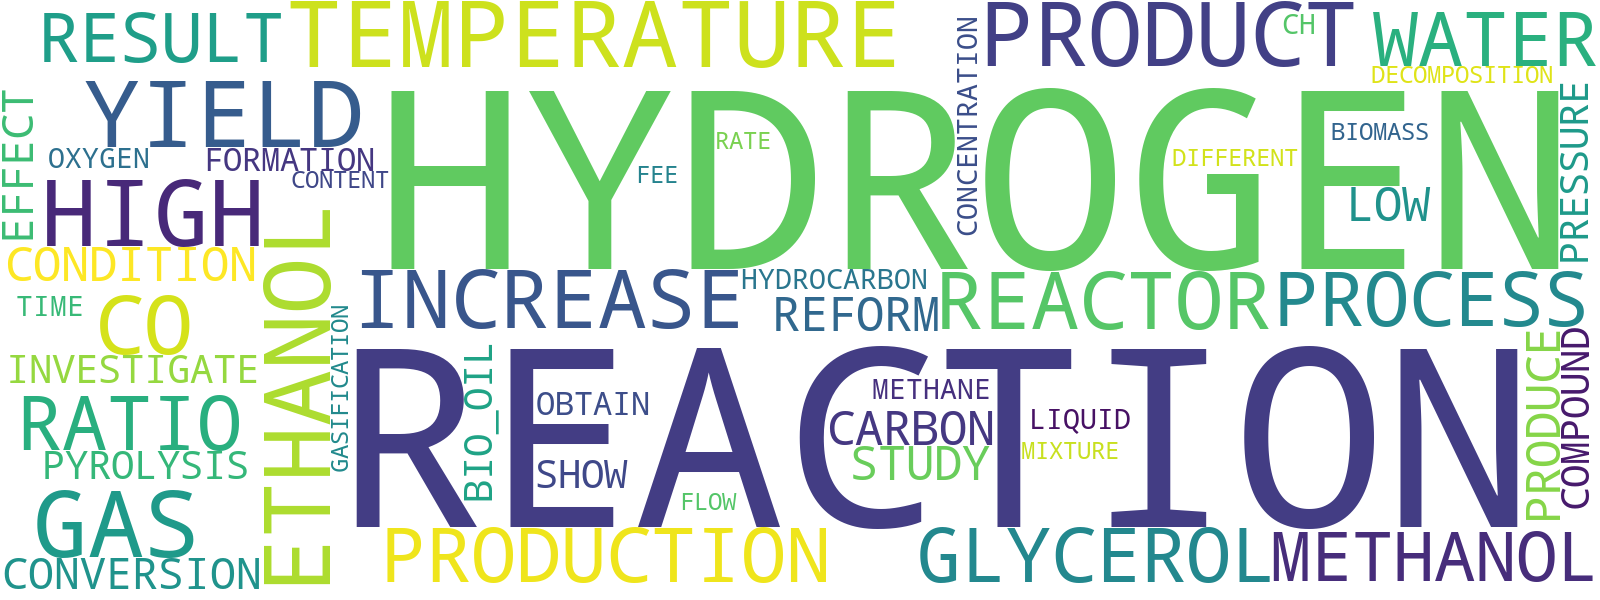

In [47]:
from wordcloud import WordCloud

# Joining all the processed lines together. Whole PDF
long_string = ','.join([str(i) for i in list(topics_df['Terms per Topic'][4])])
# WordCloud object
wordcloud = WordCloud(background_color="white",
                      max_words=100000, 
                      contour_width=5, 
                      contour_color='steelblue',
                      repeat = False,
                      relative_scaling = 0.5,
                      min_font_size=10,
                      max_font_size = 250,
                      width=1600,
                      height=600)
wordcloud.generate(text=topics_df["Terms per Topic"][1].upper())

# Visualizing
wordcloud.to_image()

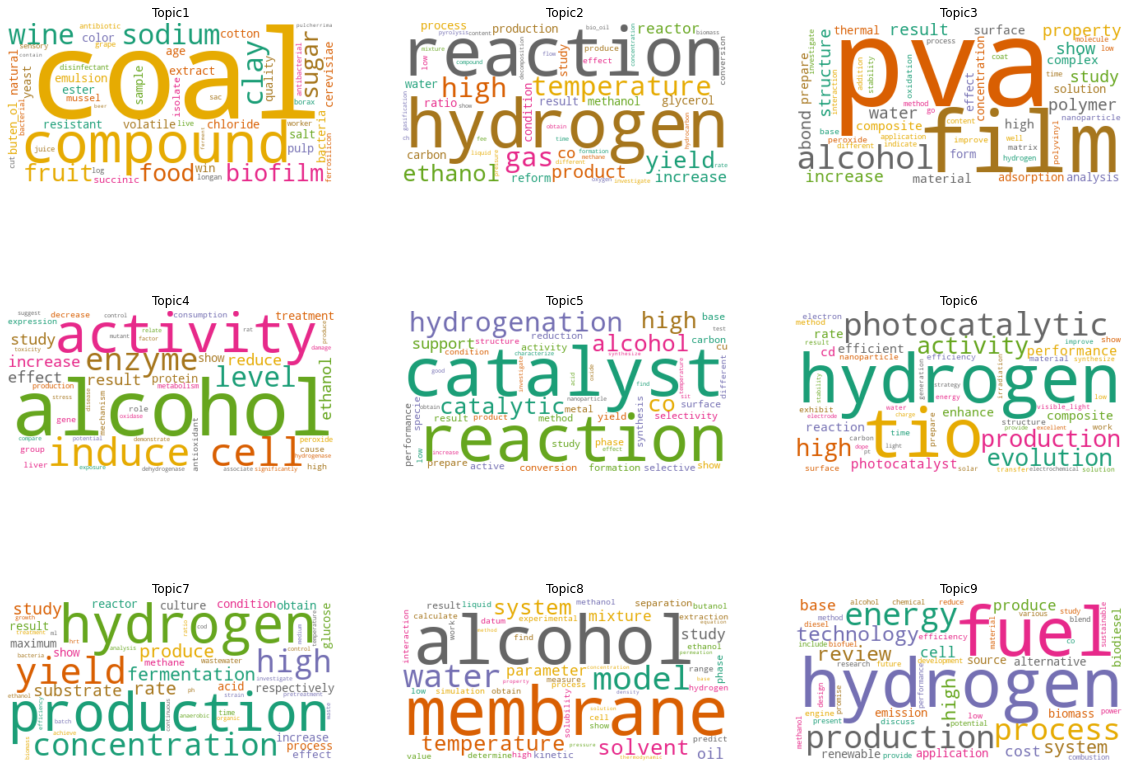

In [48]:
#Visualizing with word clouds
from wordcloud import WordCloud
#wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

#figure size
plt.rcParams['figure.figsize'] = [20, 15]

#subplots for each topic
for i in range(9):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(3, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 33306 samples in 0.093s...
[t-SNE] Computed neighbors for 33306 samples in 2.781s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33306
[t-SNE] Computed conditional probabilities for sample 2000 / 33306
[t-SNE] Computed conditional probabilities for sample 3000 / 33306
[t-SNE] Computed conditional probabilities for sample 4000 / 33306
[t-SNE] Computed conditional probabilities for sample 5000 / 33306
[t-SNE] Computed conditional probabilities for sample 6000 / 33306
[t-SNE] Computed conditional probabilities for sample 7000 / 33306
[t-SNE] Computed conditional probabilities for sample 8000 / 33306
[t-SNE] Computed conditional probabilities for sample 9000 / 33306
[t-SNE] Computed conditional probabilities for sample 10000 / 33306
[t-SNE] Computed conditional probabilities for sample 11000 / 33306
[t-SNE] Computed conditional probabilities for sample 12000 / 33306
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

No handles with labels found to put in legend.


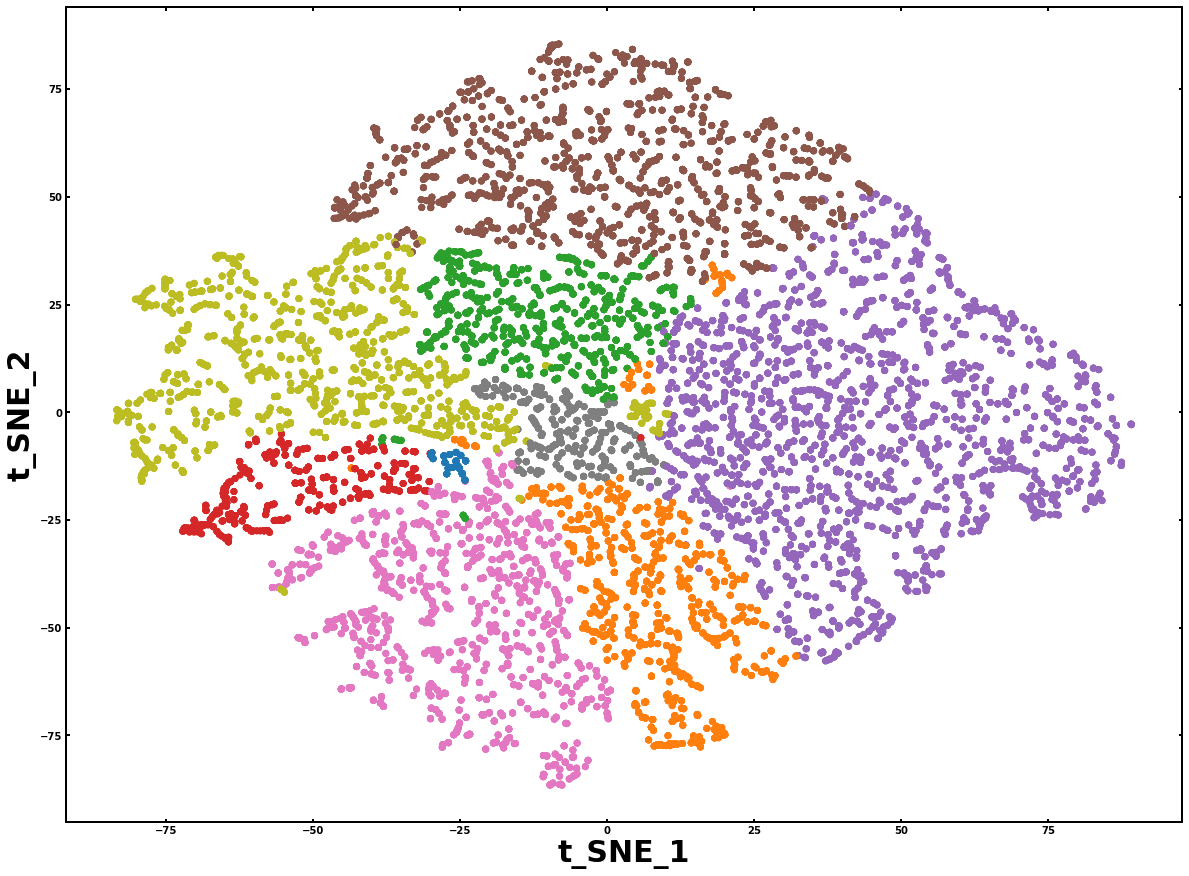

In [107]:
# Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

from matplotlib import rc

# Get topic weights
# topic_weights = []
# for i, row_list in enumerate(lda_model[corpus]):
#     topic_weights.append([w for i, w in row_list[0]])
    
# n-1 rows each is a vector with i-1 posisitons, where n the number of documents
# i the topic number and tmp[i] = probability of topic i
topic_weights = []
for row_list in lda_model[corpus]:
    tmp = np.zeros(9)
    for i, w in row_list:
        tmp[i] = w
        topic_weights.append(tmp)
arr = pd.DataFrame(topic_weights).fillna(0).values


# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 9
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
#plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)

plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

plt.xlabel('t_SNE_1',fontweight='bold', fontsize= 30)
plt.ylabel('t_SNE_2',fontweight='bold', fontsize=30)

plt.rcParams['axes.linewidth'] = 2

plt.tick_params(axis="x", direction="in",width=2)
plt.tick_params(axis="y", direction="in", width=2)

rc('font', weight='bold')

plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

#plt.legend(["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6","Topic 7","Topic 8", "Topic 9"], loc='best')
plt.legend(frameon=False,prop={'weight':'bold',"size":15})

#plt.title('LDA: Topics vs Coherence Score (alpha=0.61, beta=0.61)', fontweight='bold', fontsize=28)
plt.savefig(r'C:\Users\Admin\OneDrive - IIT Delhi\CPCB\PROF. HARI\data_final\tsne.pdf', dpi=5000)
plt.show()

Loading BokehJS ...

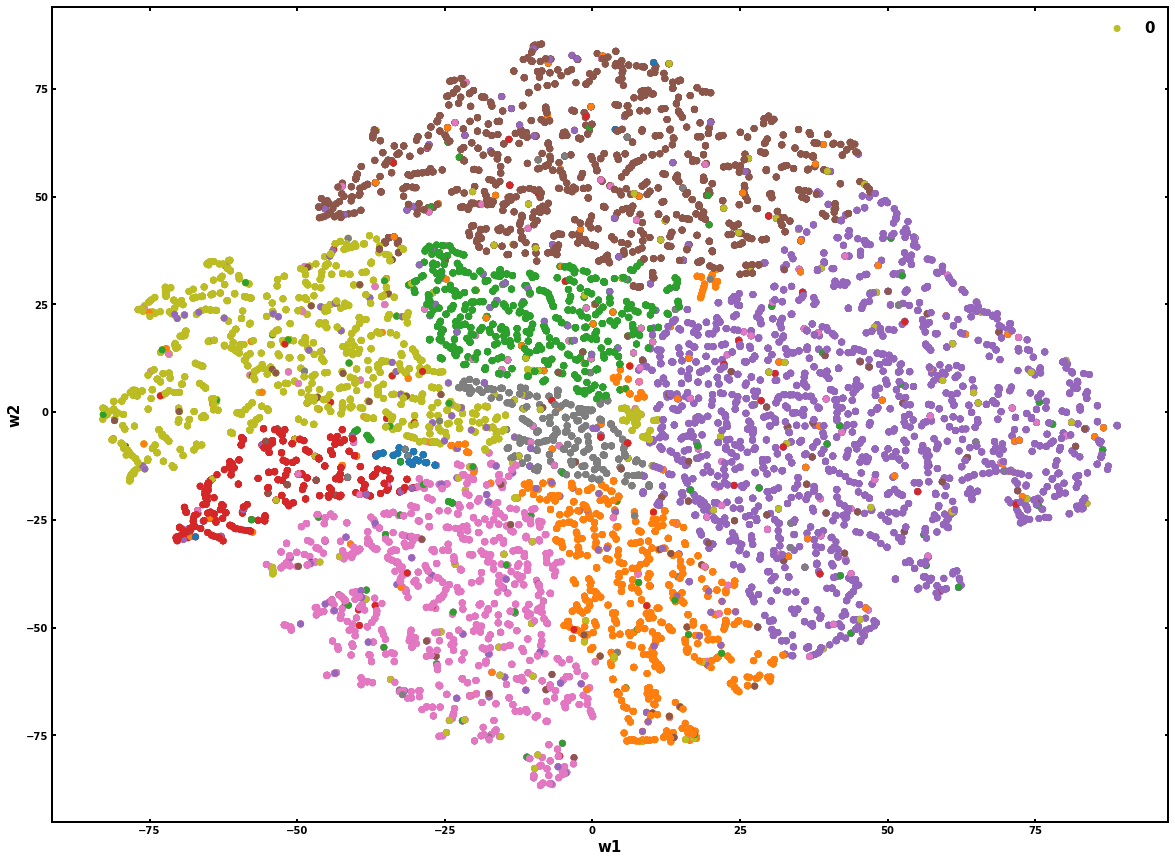

In [90]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 9
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
#plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
#for i in np.unique(topic_num):
plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], label=0)





#plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])


plt.xlabel('w1',fontweight='bold', fontsize=15)
plt.ylabel('w2',fontweight='bold', fontsize=15)

plt.rcParams['axes.linewidth'] = 2

plt.tick_params(axis="x", direction="in",width=2)
plt.tick_params(axis="y", direction="in", width=2)

rc('font', weight='bold')

plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

#plt.legend(["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6","Topic 7","Topic 8", "Topic 9"], loc='best')
plt.legend(frameon=False,prop={'weight':'bold',"size":15})

#plt.title('LDA: Topics vs Coherence Score (alpha=0.61, beta=0.61)', fontweight='bold', fontsize=28)
#plt.savefig(r'C:\Users\Admin\OneDrive - IIT Delhi\CPCB\PROF. HARI\data_final\tsne.pdf', dpi=5000)
plt.show()

In [52]:
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

SyntaxError: invalid syntax (<ipython-input-52-b8dc089bb763>, line 1)

In [53]:
for name, color in mcolors.TABLEAU_COLORS.items():
    print(name)

tab:blue
tab:orange
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:gray
tab:olive
tab:cyan


In [57]:
tsne_lda

array([[  5.488515 ,   0.9287962],
       [  5.4883513,   0.9290175],
       [  5.4883513,   0.9290175],
       ...,
       [ 38.015835 , -35.367428 ],
       [ 38.01639  , -35.367355 ],
       [ 38.01639  , -35.367355 ]], dtype=float32)

In [56]:
groups = pd.DataFrame(tsne_lda, columns=['x', 'y']).assign(category=y).groupby('category')

NameError: name 'y' is not defined

In [58]:
# Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

from matplotlib import rc

# Get topic weights
# topic_weights = []
# for i, row_list in enumerate(lda_model[corpus]):
#     topic_weights.append([w for i, w in row_list[0]])
    
# n-1 rows each is a vector with i-1 posisitons, where n the number of documents
# i the topic number and tmp[i] = probability of topic i
topic_weights = []
for row_list in lda_model[corpus]:
    tmp = np.zeros(9)
    for i, w in row_list:
        tmp[i] = w
        topic_weights.append(tmp)
arr = pd.DataFrame(topic_weights).fillna(0).values


# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [62]:
np.unique(topic_num)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [65]:
np.shape(arr)

(33306, 9)

In [71]:
df = pd.DataFrame(arr)
df['a'] =  topic_num

In [72]:
df.head()

,0,1,2,3,4,5,6,7,8,a
0,0.0,0.015682,0.073972,0.0,0.296465,0.021467,0.0,0.0,0.559984,8
1,0.0,0.015682,0.073972,0.0,0.296465,0.021467,0.0,0.0,0.559984,8
2,0.0,0.015682,0.073972,0.0,0.296465,0.021467,0.0,0.0,0.559984,8
3,0.0,0.015682,0.073972,0.0,0.296465,0.021467,0.0,0.0,0.559984,8
4,0.0,0.015682,0.073972,0.0,0.296465,0.021467,0.0,0.0,0.559984,8


0
1
2
3
4
5
6
7
8


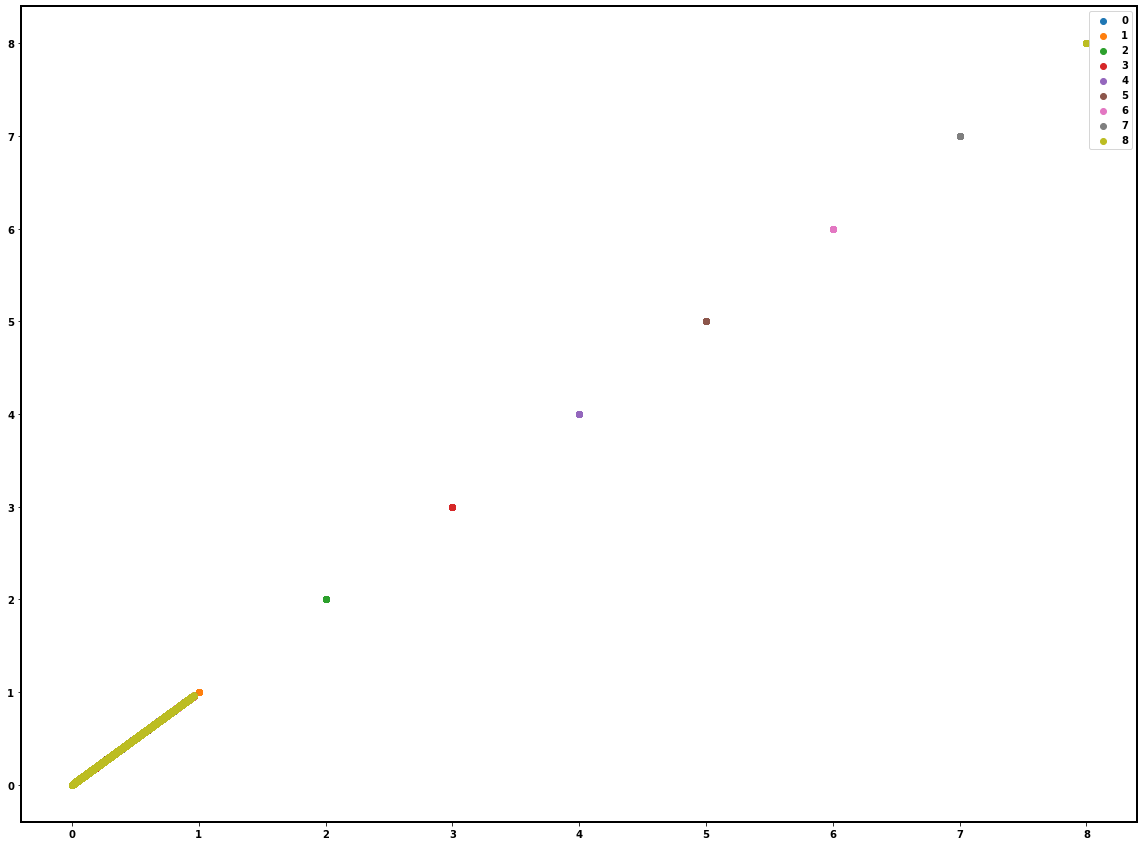

In [78]:
for i in np.unique(topic_num):
    print(i)
    
    plt.scatter(df[df['a'] == i] , df[df['a'] == i] , label = i)
plt.legend()
plt.show()

In [80]:
np.shape(tsne_lda[:,0])

(33306,)

In [83]:
np.shape(tsne_lda)

(33306, 2)

In [84]:
df_ = pd.DataFrame(tsne_lda)

In [86]:
df_['labels'] =  topic_num

In [102]:
def plot_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    print(palette)
    
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1],  c=palette[colors.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
# add the labels for each digit corresponding to the label
    txts = []
    for i in range(num_classes):
    # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    return f, ax, sc, txts

[[0.86       0.3712     0.34      ]
 [0.86       0.71786667 0.34      ]
 [0.65546667 0.86       0.34      ]
 [0.34       0.86       0.3712    ]
 [0.34       0.86       0.71786667]
 [0.34       0.65546667 0.86      ]
 [0.3712     0.34       0.86      ]
 [0.71786667 0.34       0.86      ]
 [0.86       0.34       0.65546667]]


ValueError: 'c' argument has 33306 elements, which is inconsistent with 'x' and 'y' with size 33307.

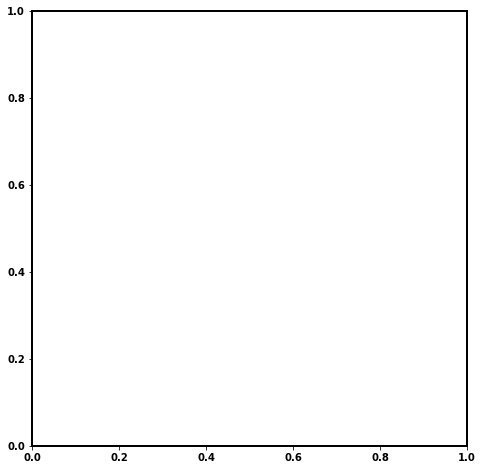

In [104]:
plot_scatter( tsne_lda, df_['labels'])

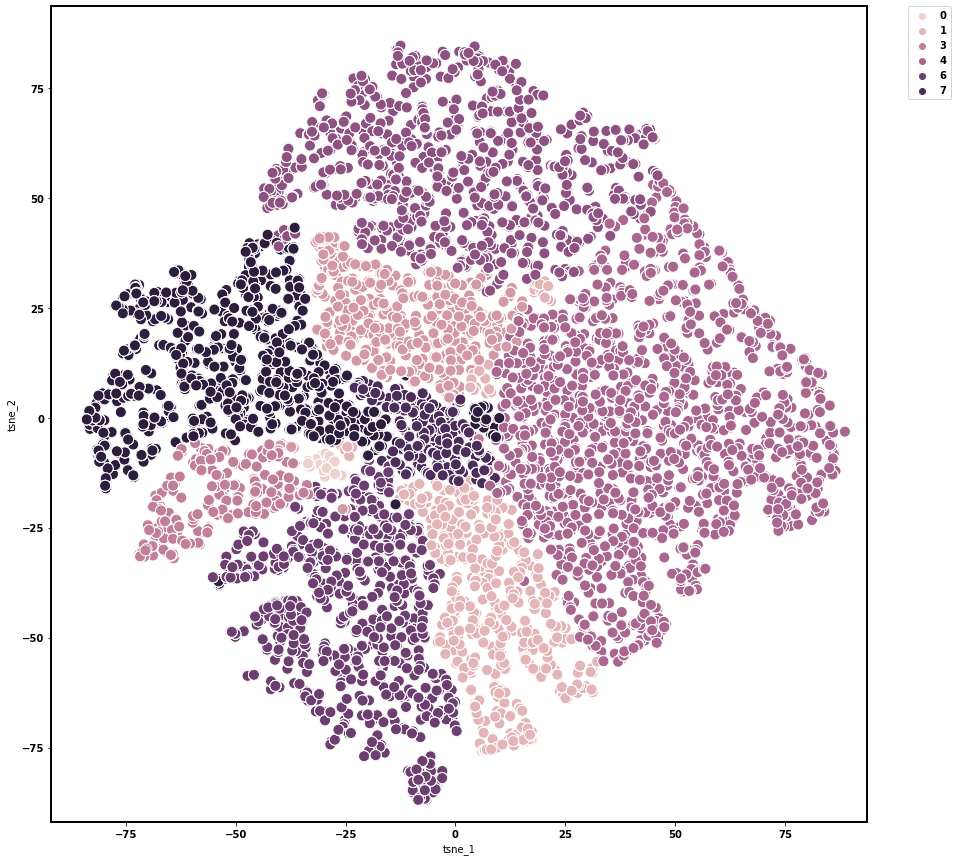

In [99]:
import seaborn as sns
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_lda[:,0], 'tsne_2': tsne_lda[:,1], 'label':topic_num })
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_lda.min()-5, tsne_lda.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)